# Compare models

1. Load available configurations
2. Load validation predictions
    - calculate absolute error
    - select top N for plotting by MAE from smallest (best) to largest (worst) (top N as specified, default 5)
    - correlation per sample, correlation per feat, correlation overall
    - MAE plots
3. Load test data predictions
    - as for validation data
    - top N based on validation data

In [1]:
import logging
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from IPython.display import display

import pimmslearn
import pimmslearn.imputation
import pimmslearn.models
import pimmslearn.nb
from pimmslearn.analyzers import compare_predictions
from pimmslearn.io import datasplits
from pimmslearn.models.collect_dumps import collect, select_content

pd.options.display.max_rows = 30
pd.options.display.min_rows = 10
pd.options.display.max_colwidth = 100

plt.rcParams.update({'figure.figsize': (4, 2)})
pimmslearn.plotting.make_large_descriptors(7)

logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.WARNING)


def load_config_file(fname: Path, first_split='config_') -> dict:
    with open(fname) as f:
        loaded = yaml.safe_load(f)
    key = f"{select_content(fname.stem, first_split=first_split)}"
    return key, loaded


def build_text(s):
    ret = ''
    if not np.isnan(s["latent_dim"]):
        ret += f'LD: {int(s["latent_dim"])} '
    try:
        if len(s["hidden_layers"]):
            t = ",".join(str(x) for x in s["hidden_layers"])
            ret += f"HL: {t}"
    except TypeError:
        # nan
        pass
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
models: str = 'Median,CF,DAE,VAE'  # picked models to compare (comma separated)
sel_models: str = ''  # user defined comparison (comma separated)
# Restrict plotting to top N methods for imputation based on error of validation data, maximum 10
plot_to_n: int = 5
feat_name_display: str = None  # display name for feature name in plural (e.g. 'protein groups')
save_agg_pred: bool = False  # save aggregated predictions of validation and test data

In [4]:
# Parameters
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"
models = "Median,CF,DAE,VAE,KNN,KNN5,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO"


Some argument transformations

In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args

root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: fn_rawfile_metadata


root - INFO     Removed from global namespace: models


root - INFO     Removed from global namespace: sel_models


root - INFO     Removed from global namespace: plot_to_n


root - INFO     Removed from global namespace: feat_name_display


root - INFO     Removed from global namespace: save_agg_pred


{'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'models': 'Median,CF,DAE,VAE,KNN,KNN5,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO',
 'sel_models': '',
 'plot_to_n': 5,
 'feat_name_display': None,
 'save_agg_pred': False}

In [6]:
args = pimmslearn.nb.args_from_dict(args)
args

{'data': Path('runs/alzheimer_study/data'),
 'feat_name_display': None,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'models': 'Median,CF,DAE,VAE,KNN,KNN5,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO',
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'plot_to_n': 5,
 'save_agg_pred': False,
 'sel_models': ''}

In [7]:
figures = {}
dumps = {}

In [8]:
TARGET_COL = 'observed'
METRIC = 'MAE'
MIN_FREQ = None
MODELS_PASSED = args.models.split(',')
MODELS = MODELS_PASSED.copy()
FEAT_NAME_DISPLAY = args.feat_name_display
SEL_MODELS = None
if args.sel_models:
    SEL_MODELS = args.sel_models.split(',')

In [9]:
# list(sns.color_palette().as_hex()) # string representation of colors
if args.plot_to_n > 10:
    logger.warning("Set maximum of models to 10 (maximum)")
    args.overwrite_entry('plot_to_n', 10)

In [10]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_fake_na_val_test_splits.png


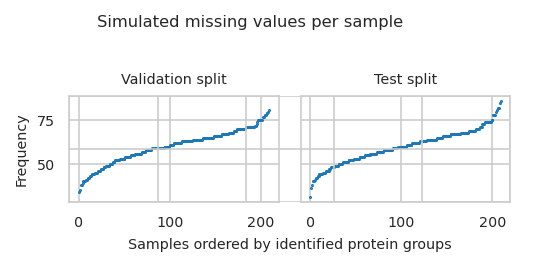

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)

pimmslearn.plotting.data.plot_observations(data.val_y.unstack(), ax=axes[0],
                                     title='Validation split', size=1, xlabel='')
pimmslearn.plotting.data.plot_observations(data.test_y.unstack(), ax=axes[1],
                                     title='Test split', size=1, xlabel='')
fig.suptitle("Simulated missing values per sample", size=8)
# hide axis and use only for common x label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(f'Samples ordered by identified {data.val_y.index.names[-1]}')
group = 1
fname = args.out_figures / f'2_{group}_fake_na_val_test_splits.png'
figures[fname.stem] = fname
pimmslearn.savefig(fig, name=fname)

## data completeness across entire data

In [12]:
# load frequency of training features...
# needs to be pickle -> index.name needed
freq_feat = pimmslearn.io.datasplits.load_freq(args.data, file='freq_features.json')
freq_feat.head()  # training data

A0A024QZX5;A0A087X1N8;P35237                                                     197
A0A024R0T9;K7ER74;P02655                                                         208
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   185
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          208
A0A075B6H7                                                                        97
Name: freq, dtype: int64

<Axes: xlabel='protein groups', ylabel='Proportion of identification in samples'>

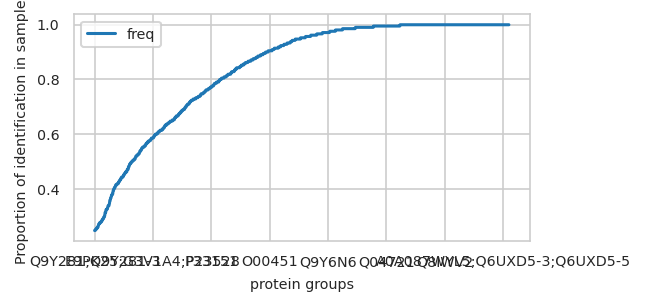

In [13]:
prop = freq_feat / len(data.train_X.index.levels[0])
prop.sort_values().to_frame().plot(
    xlabel=f'{data.val_y.index.names[-1]}',
    ylabel='Proportion of identification in samples')

View training data in wide format

In [14]:
data.to_wide_format()
data.train_X

protein groups  A0A024QZX5;A0A087X1N8;P35237  A0A024R0T9;K7ER74;P02655  \
Sample ID                                                                
Sample_000                            15.912                    16.852   
Sample_001                               NaN                    16.874   
Sample_002                            16.111                       NaN   
Sample_003                            16.107                    17.032   
Sample_004                            15.603                    15.331   
...                                      ...                       ...   
Sample_205                            15.682                    16.886   
Sample_206                            15.798                    17.554   
Sample_207                            15.739                       NaN   
Sample_208                            15.477                    16.779   
Sample_209                               NaN                    17.261   

protein groups  A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8  \
Sample ID                                                                                        
Sample_000                                                                              15.570   
Sample_001                                                                              15.519   
Sample_002                                                                              15.935   
Sample_003                                                                              15.802   
Sample_004                                                                              15.375   
...                                                                                        ...   
Sample_205                                                                              14.910   
Sample_206                                                                              15.600   
Sample_207                                                                              15.469   
Sample_208                                                                              14.995   
Sample_209                                                                              15.175   

protein groups  A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503  A0A075B6H7  \
Sample ID                                                             
Sample_000                                       16.481      17.301   
Sample_001                                       16.387         NaN   
Sample_002                                       16.416      18.175   
Sample_003                                       16.979      15.963   
Sample_004                                       16.679         NaN   
...                                                 ...         ...   
Sample_205                                       16.482         NaN   
Sample_206                                       15.938         NaN   
Sample_207                                       16.898         NaN   
Sample_208                                       16.132         NaN   
Sample_209                                       16.235         NaN   

protein groups  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6I6  A0A075B6I9  \
Sample ID                                                                    
Sample_000          20.246      16.764      17.584      16.988      20.054   
Sample_001          19.941      18.786      17.144         NaN      19.067   
Sample_002          19.251      16.832      15.671      17.012      18.569   
Sample_003          19.628      17.852      18.877      14.182      18.985   
Sample_004          20.450      18.682      17.081      14.140      19.686   
...                    ...         ...         ...         ...         ...   
Sample_205          17.705      17.039         NaN      16.413      19.102   
Sample_206          18.154      18.152      16.503      16.860      18.538   
Sample_207          18.636      17.950      16.321      16

Number of samples and features:

In [15]:
N_SAMPLES, M_FEAT = data.train_X.shape
print(f"N samples: {N_SAMPLES:,d}, M features: {M_FEAT}")

N samples: 210, M features: 1421


Collect outputs in excel file:

In [16]:
fname = args.folder_experiment / '01_2_performance_summary.xlsx'
dumps[fname.stem] = fname
writer = pd.ExcelWriter(fname)
print(f"Saving to: {fname}")

Saving to: runs/alzheimer_study/01_2_performance_summary.xlsx


## Model specifications
- used for bar plot annotations

In [17]:
# model_key could be used as key from config file
# ? load only specified configs?
# ? case: no config file available?
all_configs = collect(
    paths=(fname for fname in args.out_models.iterdir()
           if fname.suffix == '.yaml'
           and 'model_config' in fname.name),
    load_fn=load_config_file
)
model_configs = pd.DataFrame(all_configs).set_index('id')
model_configs.T.to_excel(writer, sheet_name='model_params')
model_configs.T

id                                                                                                              VAE  \
M                                                                                                              1421   
batch_size                                                                                                   64.000   
cuda                                                                                                          False   
data                                                                                      runs/alzheimer_study/data   
epoch_trained                                                                                               107.000   
epochs_max                                                                                                  300.000   
file_format                                                                                                     csv   
fn_rawfile_metadata  https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv   
folder_data                                                                                                           
folder_experiment                                                                              runs/alzheimer_study   
hidden_layers                                                                                                  [64]   
latent_dim                                                                                                   10.000   
meta_cat_col                                                                                                    NaN   
meta_date_col                                                                                                   NaN   
model                                                                                                           VAE   
model_key                                                                                                       VAE   
n_params                                                                                                     277998   
out_figures                                                                            runs/alzheimer_study/figures   
out_folder                                                                                     runs/alzheimer_study   
out_metrics                                                                                    runs/alzheimer_study   
out_models                                                                                     runs/alzheimer_study   
out_preds                                                                                runs/alzheimer_study/preds   
patience                                                                                                     50.000   
sample_idx_position                                                                                               0   
save_pred_real_na                                                                                              True   
force_train                                                                                                     NaN   
neighbors                                                                                                       NaN   
pred_test_Median                                                                                                NaN   
pred_val_Median                                                                                                 NaN   

id                                                                                                             KNN5  \
M                                                                                                              1421   
batch_size                                                                                                   64.000   
cuda                                                                    

Set Feature name (columns are features, rows are samples)

In [18]:
# index name
freq_feat.index.name = data.train_X.columns.name
# sample index name
sample_index_name = data.train_X.index.name

# Load predictions on validation and test data split


## Validation data
- set top N models to plot based on validation data split

In [19]:
pred_val = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='val',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
SAMPLE_ID, FEAT_NAME = pred_val.index.names
if not FEAT_NAME_DISPLAY:
    FEAT_NAME_DISPLAY = FEAT_NAME
pred_val[MODELS]

Median     CF    DAE    VAE  \
Sample ID  protein groups                                                   
Sample_158 Q9UN70;Q9UN70-2                    15.752 15.383 15.590 15.716   
Sample_050 Q9Y287                             17.221 16.713 16.721 16.778   
Sample_107 Q8N475;Q8N475-2                    14.846 14.252 14.021 14.275   
Sample_199 P06307                             18.973 19.205 18.697 19.127   
Sample_067 Q5VUB5                             14.726 14.855 15.179 14.968   
...                                              ...    ...    ...    ...   
Sample_111 F6SYF8;Q9UBP4                      22.918 23.224 23.040 22.869   
Sample_002 A0A0A0MT36                         15.877 15.392 15.755 16.131   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4  16.278 15.616 15.822 15.699   
Sample_182 Q8NFT8                             13.995 13.650 13.557 13.283   
Sample_123 Q16853;Q16853-2                    14.849 14.488 14.539 14.566   

                                                KNN   KNN5   BPCA  COLMEDIAN  \
Sample ID  protein groups                                                      
Sample_158 Q9UN70;Q9UN70-2                   15.427 15.449 15.469     16.800   
Sample_050 Q9Y287                            17.776 17.314 16.453     17.288   
Sample_107 Q8N475;Q8N475-2                   14.150 14.355 13.110     17.187   
Sample_199 P06307                            19.247 19.385 19.639     16.711   
Sample_067 Q5VUB5                            15.232 15.040 15.465     16.743   
...                                             ...    ...    ...        ...   
Sample_111 F6SYF8;Q9UBP4                     22.884 22.899 22.994     17.042   
Sample_002 A0A0A0MT36                        16.857 16.142 15.882     16.792   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4 15.840 15.574 15.406     17.032   
Sample_182 Q8NFT8                            13.685 13.480 14.322     16.764   
Sample_123 Q16853;Q16853-2                   14.612 14.627 14.582     16.686   

                                              IMPSEQ  IMPSEQROB  ...  MINIMUM  \
Sample ID  protein groups                                        ...            
Sample_158 Q9UN70;Q9UN70-2                       NaN     58.276  ...    7.068   
Sample_050 Q9Y287                                NaN     16.993  ...    7.068   
Sample_107 Q8N475;Q8N475-2                       NaN    -78.084  ...    7.068   
Sample_199 P06307                                NaN    102.283  ...    7.068   
Sample_067 Q5VUB5                                NaN    -36.470  ...    7.068   
...                                              ...        ...  ...      ...   
Sample_111 F6SYF8;Q9UBP4                         NaN    104.484  ...    7.068   
Sample_002 A0A0A0MT36                            NaN    -18.408  ...    7.068   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4     NaN    -27.128  ...    7.068   
Sample_182 Q8NFT8                                NaN    -12.434  ...    7.068   
Sample_123 Q16853;Q16853-2                       NaN     78.799  ...    7.068   

                                              MINPROB       MLE     PI  QRILC  \
Sample ID  protein groups                                                       
Sample_158 Q9UN70;Q9UN70-2                     11.759 2,513.638 13.686 14.684   
Sample_050 Q9Y287                              11.661    19.829 12.756 15.985   
Sample_107 Q8N475;Q8N475-2                     11.758 2,582.130 12.748 13.426   
Sample_199 P06307                              12.699 2,483.120 12.973 17.354   
Sample_067 Q5VUB5                              11.790 2,569.564 13.254 12.685   
...                                               ...       ...    ...    ...   
Sample_111 F6SYF8;Q9UBP4                       12.253 2,634.108 12.200 22.290   
Sample_002 A0A0A0MT36                          12.826 2,448.503 11.867 13.208   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4   11.813 2,487.550 14.168 14.056   
Sample_182 Q8NFT8                              11.421 2,42

Describe absolute error

In [20]:
errors_val = (pred_val
              .drop(TARGET_COL, axis=1)
              .sub(pred_val[TARGET_COL], axis=0)
              [MODELS])
errors_val  # over all samples and all features

Median     CF    DAE    VAE  \
Sample ID  protein groups                                                   
Sample_158 Q9UN70;Q9UN70-2                     1.122  0.753  0.959  1.085   
Sample_050 Q9Y287                              1.466  0.958  0.966  1.023   
Sample_107 Q8N475;Q8N475-2                    -0.183 -0.777 -1.009 -0.754   
Sample_199 P06307                             -0.403 -0.171 -0.679 -0.249   
Sample_067 Q5VUB5                             -0.583 -0.454 -0.130 -0.341   
...                                              ...    ...    ...    ...   
Sample_111 F6SYF8;Q9UBP4                       0.096  0.402  0.218  0.047   
Sample_002 A0A0A0MT36                         -2.288 -2.773 -2.410 -2.034   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4   0.753  0.091  0.297  0.173   
Sample_182 Q8NFT8                             -0.383 -0.728 -0.822 -1.096   
Sample_123 Q16853;Q16853-2                     0.345 -0.017  0.035  0.062   

                                                KNN   KNN5   BPCA  COLMEDIAN  \
Sample ID  protein groups                                                      
Sample_158 Q9UN70;Q9UN70-2                    0.797  0.819  0.839      2.169   
Sample_050 Q9Y287                             2.021  1.559  0.698      1.533   
Sample_107 Q8N475;Q8N475-2                   -0.880 -0.674 -1.919      2.157   
Sample_199 P06307                            -0.129  0.009  0.263     -2.665   
Sample_067 Q5VUB5                            -0.077 -0.269  0.156      1.434   
...                                             ...    ...    ...        ...   
Sample_111 F6SYF8;Q9UBP4                      0.062  0.077  0.171     -5.781   
Sample_002 A0A0A0MT36                        -1.308 -2.023 -2.283     -1.373   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4  0.314  0.049 -0.120      1.507   
Sample_182 Q8NFT8                            -0.694 -0.899 -0.057      2.385   
Sample_123 Q16853;Q16853-2                    0.108  0.123  0.077      2.181   

                                              IMPSEQ  IMPSEQROB  ...  MINIMUM  \
Sample ID  protein groups                                        ...            
Sample_158 Q9UN70;Q9UN70-2                       NaN     43.645  ...   -7.562   
Sample_050 Q9Y287                                NaN      1.238  ...   -8.687   
Sample_107 Q8N475;Q8N475-2                       NaN    -93.113  ...   -7.961   
Sample_199 P06307                                NaN     82.907  ...  -12.308   
Sample_067 Q5VUB5                                NaN    -51.779  ...   -8.241   
...                                              ...        ...  ...      ...   
Sample_111 F6SYF8;Q9UBP4                         NaN     81.662  ...  -15.754   
Sample_002 A0A0A0MT36                            NaN    -36.573  ...  -11.097   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4     NaN    -42.653  ...   -8.457   
Sample_182 Q8NFT8                                NaN    -26.813  ...   -7.311   
Sample_123 Q16853;Q16853-2                       NaN     64.295  ...   -7.436   

                                              MINPROB       MLE      PI  \
Sample ID  protein groups                                                 
Sample_158 Q9UN70;Q9UN70-2                     -2.871 2,499.008  -0.945   
Sample_050 Q9Y287                              -4.094     4.074  -2.999   
Sample_107 Q8N475;Q8N475-2                     -3.272 2,567.100  -2.281   
Sample_199 P06307                              -6.676 2,463.744  -6.403   
Sample_067 Q5VUB5                              -3.519 2,554.255  -2.055   
...                                               ...       ...     ...   
Sample_111 F6SYF8;Q9UBP4                      -10.569 2,611.285 -10.622   
Sample_002 A0A0A0MT36                          -5.339 2,430.338  -6.298   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4   -3.712 2,472.025  -1.357   
Sample_182 Q8NFT8                              -2.958 2,411.812  -2.761   
Sample_123 Q16853;Q16853-2                     -2

### Select top N for plotting and set colors

In [21]:
ORDER_MODELS = (errors_val
                .abs()
                .mean()
                .sort_values()
                .index
                .to_list())
ORDER_MODELS

['BPCA',
 'VAE',
 'DAE',
 'TRKNN',
 'RF',
 'CF',
 'KNN5',
 'KNN',
 'KNN_IMPUTE',
 'IRM',
 'ROWMEDIAN',
 'Median',
 'LLS',
 'QRILC',
 'COLMEDIAN',
 'SVDMETHOD',
 'PI',
 'MINDET',
 'MINPROB',
 'MINIMUM',
 'ZERO',
 'IMPSEQROB',
 'MLE',
 'IMPSEQ']

In [22]:
pred_val = pred_val[[TARGET_COL] + ORDER_MODELS]
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_val.csv'
    dumps[fname.stem] = fname
    pred_val.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_val

observed   BPCA    VAE    DAE  \
Sample ID  protein groups                                                     
Sample_158 Q9UN70;Q9UN70-2                      14.630 15.469 15.716 15.590   
Sample_050 Q9Y287                               15.755 16.453 16.778 16.721   
Sample_107 Q8N475;Q8N475-2                      15.029 13.110 14.275 14.021   
Sample_199 P06307                               19.376 19.639 19.127 18.697   
Sample_067 Q5VUB5                               15.309 15.465 14.968 15.179   
...                                                ...    ...    ...    ...   
Sample_111 F6SYF8;Q9UBP4                        22.822 22.994 22.869 23.040   
Sample_002 A0A0A0MT36                           18.165 15.882 16.131 15.755   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4    15.525 15.406 15.699 15.822   
Sample_182 Q8NFT8                               14.379 14.322 13.283 13.557   
Sample_123 Q16853;Q16853-2                      14.504 14.582 14.566 14.539   

                                              TRKNN     RF     CF   KNN5  \
Sample ID  protein groups                                                  
Sample_158 Q9UN70;Q9UN70-2                   15.700 15.652 15.383 15.449   
Sample_050 Q9Y287                            16.738 16.844 16.713 17.314   
Sample_107 Q8N475;Q8N475-2                   13.776 14.501 14.252 14.355   
Sample_199 P06307                            19.015 19.224 19.205 19.385   
Sample_067 Q5VUB5                            14.699 14.943 14.855 15.040   
...                                             ...    ...    ...    ...   
Sample_111 F6SYF8;Q9UBP4                     22.872 22.864 23.224 22.899   
Sample_002 A0A0A0MT36                        15.671 15.572 15.392 16.142   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4 15.574 15.662 15.616 15.574   
Sample_182 Q8NFT8                            14.518 13.788 13.650 13.480   
Sample_123 Q16853;Q16853-2                   14.485 14.730 14.488 14.627   

                                                KNN  KNN_IMPUTE  ...  \
Sample ID  protein groups                                        ...   
Sample_158 Q9UN70;Q9UN70-2                   15.427      15.937  ...   
Sample_050 Q9Y287                            17.776      16.961  ...   
Sample_107 Q8N475;Q8N475-2                   14.150      15.437  ...   
Sample_199 P06307                            19.247      18.861  ...   
Sample_067 Q5VUB5                            15.232      15.079  ...   
...                                             ...         ...  ...   
Sample_111 F6SYF8;Q9UBP4                     22.884      22.837  ...   
Sample_002 A0A0A0MT36                        16.857      15.446  ...   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4 15.840      15.995  ...   
Sample_182 Q8NFT8                            13.685      14.675  ...   
Sample_123 Q16853;Q16853-2                   14.612      14.824  ...   

                                              COLMEDIAN  SVDMETHOD     PI  \
Sample ID  protein groups                                                   
Sample_158 Q9UN70;Q9UN70-2                       16.800     17.206 13.686   
Sample_050 Q9Y287                                17.288     17.807 12.756   
Sample_107 Q8N475;Q8N475-2                       17.187     17.434 12.748   
Sample_199 P06307                                16.711     17.111 12.973   
Sample_067 Q5VUB5                                16.743     17.031 13.254   
...                                                 ...        ...    ...   
Sample_111 F6SYF8;Q9UBP4                         17.042     17.330 12.200   
Sample_002 A0A0A0MT36                            16.792     16.879 11.867   
Sample_049 Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4     17.032     17.215 14.168   
Sample_182 Q8NFT8                                16.764     17.125 11.618   
Sample_123 Q16853;Q16853-2                       16.686     16.981 11.338   

                                              MINDET  MINPROB  MINIMUM  ZERO  \
Sample ID 

In [23]:
mae_stats_ordered_val = errors_val.abs().describe()[ORDER_MODELS]
mae_stats_ordered_val.to_excel(writer, sheet_name='mae_stats_ordered_val', float_format='%.5f')
mae_stats_ordered_val.T

count      mean     std   min       25%       50%       75%  \
BPCA       12,600.000     0.422   0.501 0.000     0.119     0.269     0.534   
VAE        12,600.000     0.430   0.522 0.000     0.120     0.273     0.545   
DAE        12,600.000     0.431   0.521 0.000     0.120     0.270     0.541   
TRKNN      12,600.000     0.450   0.516 0.000     0.132     0.295     0.569   
RF         12,600.000     0.461   0.531 0.000     0.134     0.304     0.587   
CF         12,600.000     0.463   0.511 0.000     0.141     0.313     0.596   
KNN5       12,600.000     0.467   0.546 0.000     0.135     0.305     0.594   
KNN        12,600.000     0.481   0.565 0.000     0.138     0.310     0.618   
KNN_IMPUTE 12,600.000     0.554   0.668 0.000     0.164     0.359     0.692   
IRM        12,600.000     0.588   0.637 0.000     0.176     0.396     0.767   
ROWMEDIAN  12,600.000     0.598   0.639 0.000     0.189     0.419     0.778   
Median     12,600.000     0.598   0.639 0.000     0.189     0.419     0.778   
LLS        12,600.000     1.329  54.974 0.000     0.151     0.343     0.662   
QRILC      12,600.000     1.639   1.262 0.000     0.831     1.354     2.065   
COLMEDIAN  12,600.000     2.210   1.634 0.000     0.947     1.972     3.094   
SVDMETHOD  12,600.000     2.309   1.635 0.000     1.027     2.091     3.251   
PI         12,600.000     3.801   2.643 0.000     1.763     3.365     5.342   
MINDET     12,600.000     4.108   2.650 0.001     2.089     3.678     5.665   
MINPROB    12,600.000     4.126   2.687 0.000     2.081     3.715     5.712   
MINIMUM    12,600.000     9.272   2.717 0.373     7.327     8.890    10.863   
ZERO       12,600.000    16.340   2.717 6.695    14.395    15.958    17.931   
IMPSEQROB  12,600.000   333.478 793.700 0.002    12.282    33.864    87.298   
MLE        12,600.000 2,172.384 865.925 0.009 2,435.415 2,495.362 2,552.718   
IMPSEQ          0.000       NaN     NaN   NaN       NaN       NaN       NaN   

                 max  
BPCA           9.370  
VAE            9.931  
DAE            9.387  
TRKNN          7.975  
RF             8.970  
CF             6.038  
KNN5          10.231  
KNN           10.502  
KNN_IMPUTE     7.550  
IRM            7.953  
ROWMEDIAN      9.014  
Median         9.014  
LLS        4,842.571  
QRILC         15.188  
COLMEDIAN     12.944  
SVDMETHOD     12.624  
PI            18.083  
MINDET        17.920  
MINPROB       18.426  
MINIMUM       22.773  
ZERO          29.841  
IMPSEQROB  2,869.299  
MLE        2,873.681  
IMPSEQ           NaN

Some model have fixed colors, others are assigned randomly

> Note
>
> 1. The order of "new" models is important for the color assignment.
> 2. User defined model keys for the same model with two configuration will yield different colors.

In [24]:
COLORS_TO_USE = pimmslearn.plotting.defaults.assign_colors(list(k.upper() for k in ORDER_MODELS))
pimmslearn.plotting.defaults.ModelColorVisualizer(ORDER_MODELS, COLORS_TO_USE)

pimmslearn.plotting.defaults - INFO     Reused some colors!


In [25]:
TOP_N_ORDER = ORDER_MODELS[:args.plot_to_n]
TOP_N_COLOR_PALETTE = {model: color for model,
                       color in zip(TOP_N_ORDER, COLORS_TO_USE)}
TOP_N_ORDER

['BPCA', 'VAE', 'DAE', 'TRKNN', 'RF']

### Correlation per sample

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_pred_corr_val_per_sample.pdf


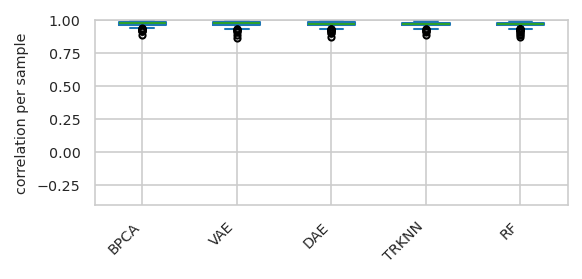

In [26]:
corr_per_sample_val = (pred_val
                       .groupby(sample_index_name)
                       .apply(
                           lambda df: df.corr().loc[TARGET_COL]
                       )[ORDER_MODELS])

min_corr = int(corr_per_sample_val.min().min() * 10) / 10
kwargs = dict(ylim=(min_corr, 1), rot=90,
              #     boxprops=dict(linewidth=1.5),
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model pred. per sample on validation data',
              ylabel='correlation per sample')
ax = corr_per_sample_val[TOP_N_ORDER].plot.box(**kwargs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)

fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.xlsx'
dumps[fname.stem] = fname
with pd.ExcelWriter(fname) as w:
    corr_per_sample_val.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_val.to_excel(w, sheet_name='correlations')
    corr_per_sample_val[TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [27]:
treshold = pimmslearn.pandas.get_lower_whiskers(
    corr_per_sample_val[TOP_N_ORDER]).min()
mask = (corr_per_sample_val[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_val.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

### Error plot

In [28]:
c_error_min = 4.5
mask = (errors_val[MODELS].abs() > c_error_min).any(axis=1)
errors_val.loc[mask].sort_index(level=1).head()

Median     CF    DAE    VAE    KNN  \
Sample ID  protein groups                                                     
Sample_012 A0A024QZX5;A0A087X1N8;P35237  -0.324 -0.161 -0.263 -0.279 -0.246   
Sample_017 A0A024QZX5;A0A087X1N8;P35237   0.347  0.287  0.409  0.332 -0.093   
Sample_050 A0A024QZX5;A0A087X1N8;P35237   0.544  0.146  0.086  0.092  0.024   
Sample_102 A0A024QZX5;A0A087X1N8;P35237  -0.029 -0.084 -0.152 -0.096  0.030   
Sample_109 A0A024QZX5;A0A087X1N8;P35237   0.343 -0.348 -0.096 -0.109 -0.179   

                                          KNN5   BPCA  COLMEDIAN  IMPSEQ  \
Sample ID  protein groups                                                  
Sample_012 A0A024QZX5;A0A087X1N8;P35237 -0.416 -0.140      0.856     NaN   
Sample_017 A0A024QZX5;A0A087X1N8;P35237 -0.022  0.251      1.658     NaN   
Sample_050 A0A024QZX5;A0A087X1N8;P35237 -0.102  0.178      2.207     NaN   
Sample_102 A0A024QZX5;A0A087X1N8;P35237  0.067 -0.107      0.942     NaN   
Sample_109 A0A024QZX5;A0A087X1N8;P35237 -0.004 -0.263      1.518     NaN   

                                         IMPSEQROB  ...  MINIMUM  MINPROB  \
Sample ID  protein groups                           ...                     
Sample_012 A0A024QZX5;A0A087X1N8;P35237    -53.608  ...   -8.881   -3.987   
Sample_017 A0A024QZX5;A0A087X1N8;P35237     26.724  ...   -8.211   -3.184   
Sample_050 A0A024QZX5;A0A087X1N8;P35237      0.348  ...   -8.013   -2.146   
Sample_102 A0A024QZX5;A0A087X1N8;P35237     19.277  ...   -8.586   -3.708   
Sample_109 A0A024QZX5;A0A087X1N8;P35237    -28.795  ...   -8.215   -3.515   

                                           MLE     PI  QRILC     RF  \
Sample ID  protein groups                                             
Sample_012 A0A024QZX5;A0A087X1N8;P35237  0.632 -2.230 -1.588 -0.293   
Sample_017 A0A024QZX5;A0A087X1N8;P35237  1.228 -2.086 -1.311  0.255   
Sample_050 A0A024QZX5;A0A087X1N8;P35237  3.294 -2.553 -0.212 -0.085   
Sample_102 A0A024QZX5;A0A087X1N8;P35237  1.609 -2.349 -0.897 -0.138   
Sample_109 A0A024QZX5;A0A087X1N8;P35237 -2.077 -2.497 -0.340 -0.021   

                                         ROWMEDIAN  SVDMETHOD  TRKNN    ZERO  
Sample ID  protein groups                                                     
Sample_012 A0A024QZX5;A0A087X1N8;P35237     -0.324      1.241 -0.318 -15.949  
Sample_017 A0A024QZX5;A0A087X1N8;P35237      0.347      2.214  0.305 -15.279  
Sample_050 A0A024QZX5;A0A087X1N8;P35237      0.544      2.691  0.238 -15.081  
Sample_102 A0A024QZX5;A0A087X1N8;P35237     -0.029      1.168 -0.065 -15.654  
Sample_109 A0A024QZX5;A0A087X1N8;P35237      0.343      1.968 -0.012 -15.283  

[5 rows x 24 columns]

In [29]:
errors_val = errors_val.abs().groupby(
    freq_feat.index.name).mean()  # absolute error
errors_val = errors_val.join(freq_feat)
errors_val = errors_val.sort_values(by=freq_feat.name, ascending=True)
errors_val.head()

Median    CF   DAE   VAE   KNN  \
protein groups                                                             
Q9Y281;Q9Y281-3                            0.415 0.283 0.258 0.363 0.325   
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4   0.331 0.568 0.375 0.391 0.281   
B1AJQ6;Q86Y82                              1.082 0.902 0.887 0.825 0.482   
P69892                                     0.872 1.471 1.728 1.318 1.734   
A2RU67                                     0.689 0.545 0.480 0.496 0.503   

                                          KNN5  BPCA  COLMEDIAN  IMPSEQ  \
protein groups                                                            
Q9Y281;Q9Y281-3                          0.285 0.266      4.078     NaN   
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4 0.385 0.387      3.029     NaN   
B1AJQ6;Q86Y82                            1.226 0.674      3.367     NaN   
P69892                                   1.286 1.360      1.980     NaN   
A2RU67                                   0.462 0.539      4.495     NaN   

                                          IMPSEQROB  ...  MINPROB       MLE  \
protein groups                                       ...                      
Q9Y281;Q9Y281-3                              10.519  ...    0.546 2,473.194   
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4     13.344  ...    1.243 2,525.930   
B1AJQ6;Q86Y82                                 5.026  ...    1.830 2,441.128   
P69892                                       18.023  ...    2.506 2,532.051   
A2RU67                                       15.116  ...    1.108 1,998.072   

                                            PI  QRILC    RF  ROWMEDIAN  \
protein groups                                                           
Q9Y281;Q9Y281-3                          0.570  1.274 0.376      0.415   
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4 0.866  2.143 0.287      0.331   
B1AJQ6;Q86Y82                            0.048  0.599 1.169      1.082   
P69892                                   2.568  7.668 1.411      0.872   
A2RU67                                   1.220  1.398 0.571      0.689   

                                          SVDMETHOD  TRKNN   ZERO  freq  
protein groups                                                           
Q9Y281;Q9Y281-3                               4.472  0.307 12.573    52  
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4      3.452  0.257 13.857    52  
B1AJQ6;Q86Y82                                 3.926  0.900 13.380    52  
P69892                                        2.320  0.966 14.768    53  
A2RU67                                        4.870  0.462 12.437    53  

[5 rows x 25 columns]

In [30]:
errors_val.describe()[ORDER_MODELS].T  # mean of means

count      mean     std    min       25%       50%       75%  \
BPCA       1,419.000     0.408   0.306  0.017     0.222     0.320     0.494   
VAE        1,419.000     0.419   0.321  0.014     0.229     0.333     0.490   
DAE        1,419.000     0.420   0.325  0.028     0.227     0.325     0.496   
TRKNN      1,419.000     0.437   0.309  0.000     0.241     0.349     0.526   
RF         1,419.000     0.448   0.318  0.051     0.253     0.361     0.538   
CF         1,419.000     0.450   0.303  0.028     0.260     0.368     0.532   
KNN5       1,419.000     0.455   0.322  0.039     0.256     0.369     0.540   
KNN        1,419.000     0.468   0.333  0.012     0.267     0.375     0.549   
KNN_IMPUTE 1,419.000     0.531   0.378  0.063     0.296     0.424     0.636   
IRM        1,419.000     0.555   0.372  0.030     0.311     0.449     0.674   
ROWMEDIAN  1,419.000     0.580   0.359  0.094     0.351     0.487     0.691   
Median     1,419.000     0.580   0.359  0.094     0.351     0.487     0.691   
LLS        1,419.000     1.088  19.029  0.023     0.279     0.408     0.596   
QRILC      1,419.000     1.611   0.868  0.319     1.041     1.369     1.885   
COLMEDIAN  1,419.000     2.071   1.509  0.038     0.916     1.738     2.812   
SVDMETHOD  1,419.000     2.136   1.467  0.149     0.976     1.893     2.905   
PI         1,419.000     4.109   2.451  0.048     2.268     3.644     5.458   
MINDET     1,419.000     4.438   2.493  0.374     2.622     4.032     5.828   
MINPROB    1,419.000     4.449   2.486  0.546     2.606     3.992     5.875   
MINIMUM    1,419.000     9.620   2.542  3.842     7.854     9.231    11.051   
ZERO       1,419.000    16.688   2.542 10.910    14.922    16.299    18.119   
IMPSEQROB  1,419.000   443.657 892.834  0.830    23.477    43.842   100.325   
MLE        1,419.000 2,171.007 331.079  1.453 1,992.846 2,214.845 2,487.619   
IMPSEQ         0.000       NaN     NaN    NaN       NaN       NaN       NaN   

                 max  
BPCA           4.195  
VAE            3.708  
DAE            3.152  
TRKNN          3.647  
RF             3.415  
CF             3.126  
KNN5           3.634  
KNN            3.693  
KNN_IMPUTE     3.430  
IRM            3.476  
ROWMEDIAN      4.171  
Median         4.171  
LLS          706.018  
QRILC          7.668  
COLMEDIAN     12.631  
SVDMETHOD     12.211  
PI            16.798  
MINDET        17.100  
MINPROB       17.656  
MINIMUM       22.371  
ZERO          29.439  
IMPSEQROB  2,633.136  
MLE        2,683.431  
IMPSEQ           NaN

In [31]:
c_avg_error = 2
mask = (errors_val[TOP_N_ORDER] >= c_avg_error).any(axis=1)
errors_val.loc[mask]

Median    CF   DAE   VAE  \
protein groups                                                                  
O60512                                                2.233 1.986 1.768 2.074   
P18206;P18206-2                                       2.427 1.766 1.253 2.012   
Q99538                                                2.502 2.483 2.333 2.263   
P02100                                                2.192 1.990 2.150 2.630   
A0A0G2JRN3                                            3.053 3.126 3.152 3.708   
P01817                                                2.254 2.064 2.079 1.994   
Q15375;Q15375-4                                       4.171 1.588 1.429 1.503   
P68871                                                2.331 1.564 2.585 2.265   
Q7Z794                                                1.867 0.691 2.014 1.571   
P69905                                                2.793 2.023 2.858 2.935   
P35527                                                2.216 1.402 2.413 2.421   
P15509;P15509-2;P15509-3;P15509-5;P15509-7;P15509-8   2.252 1.073 1.864 1.683   

                                                      KNN  KNN5  BPCA  \
protein groups                                                          
O60512                                              2.293 2.209 1.989   
P18206;P18206-2                                     1.744 1.637 1.297   
Q99538                                              2.711 2.517 2.464   
P02100                                              2.283 2.509 1.033   
A0A0G2JRN3                                          3.693 3.634 4.195   
P01817                                              1.963 2.117 2.385   
Q15375;Q15375-4                                     1.608 1.331 1.981   
P68871                                              1.616 1.638 0.571   
Q7Z794                                              1.461 1.326 0.294   
P69905                                              2.936 2.820 1.032   
P35527                                              2.064 2.156 1.295   
P15509;P15509-2;P15509-3;P15509-5;P15509-7;P15509-8 1.218 1.374 1.336   

                                                     COLMEDIAN  IMPSEQ  \
protein groups                                                           
O60512                                                   5.769     NaN   
P18206;P18206-2                                          3.821     NaN   
Q99538                                                   2.615     NaN   
P02100                                                   1.996     NaN   
A0A0G2JRN3                                               3.998     NaN   
P01817                                                   2.736     NaN   
Q15375;Q15375-4                                          3.754     NaN   
P68871                                                   1.720     NaN   
Q7Z794                                                   1.853     NaN   
P69905                                                   2.807     NaN   
P35527                                                   2.273     NaN   
P15509;P15509-2;P15509-3;P15509-5;P15509-7;P15509-8      3.397     NaN   

                                                     IMPSEQROB  ...  MINPROB  \
protein groups                                                  ...            
O60512                                                   8.471  ...    1.702   
P18206;P18206-2                                          7.976  ...    1.222   
Q99538                                                   8.517  ...    2.567   
P02100                                                  14.829  ...    4.380   
A0A0G2JRN3                                              71.992  ...    7.041   
P01817                                                  10.059  ...    2.499   
Q15375;Q15375-4                                         16.223  ...    7.039   
P68871                                                  23.608  ...    3.741   
Q7Z794                                                  99

### Error by non-decimal number of intensity
- number of observations in parentheses.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/errors.py:99: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.barplot(data=errors,


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_errors_binned_by_feat_median_val.pdf


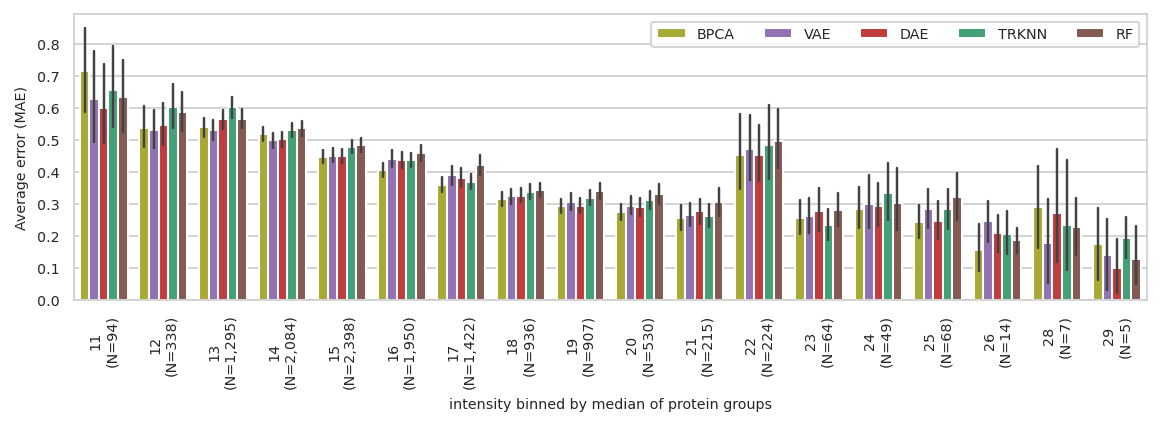

In [32]:
fig, ax = plt.subplots(figsize=(8, 3))
ax, errors_binned = pimmslearn.plotting.errors.plot_errors_by_median(
    pred_val[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,)
ax.set_ylabel(f"Average error ({METRIC})")
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_errors_binned_by_feat_median_val.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)

In [33]:
# ! only used for reporting
plotted = pimmslearn.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

bin  model  mean  ci_low  ci_high
0   11\n(N=94)   BPCA 0.715   0.601    0.849
1   11\n(N=94)    DAE 0.601   0.489    0.731
2   11\n(N=94)     RF 0.634   0.528    0.759
3   11\n(N=94)  TRKNN 0.655   0.545    0.784
4   11\n(N=94)    VAE 0.627   0.503    0.772
..         ...    ...   ...     ...      ...
85   29\n(N=5)   BPCA 0.175   0.062    0.288
86   29\n(N=5)    DAE 0.100   0.021    0.190
87   29\n(N=5)     RF 0.127   0.047    0.224
88   29\n(N=5)  TRKNN 0.193   0.128    0.257
89   29\n(N=5)    VAE 0.141   0.034    0.256

[90 rows x 5 columns]

In [34]:
errors_binned.head()
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

Sample ID   protein groups  model   MAE  bin  n_obs  \
0  Sample_158  Q9UN70;Q9UN70-2   BPCA 0.839   15  2,398   
1  Sample_158  Q9UN70;Q9UN70-2    VAE 1.085   15  2,398   
2  Sample_158  Q9UN70;Q9UN70-2    DAE 0.959   15  2,398   
3  Sample_158  Q9UN70;Q9UN70-2  TRKNN 1.070   15  2,398   
4  Sample_158  Q9UN70;Q9UN70-2     RF 1.021   15  2,398   

  intensity binned by median of protein groups  
0                                15\n(N=2,398)  
1                                15\n(N=2,398)  
2                                15\n(N=2,398)  
3                                15\n(N=2,398)  
4                                15\n(N=2,398)

## test data

In [35]:
pred_test = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='test',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
pred_test = pred_test[[TARGET_COL] + ORDER_MODELS]
pred_test = pred_test.join(freq_feat, on=freq_feat.index.name)
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_test.csv'
    dumps[fname.stem] = fname
    pred_test.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_test

observed  \
Sample ID  protein groups                                                        
Sample_000 A0A075B6P5;P01615                                            17.016   
           A0A087X089;Q16627;Q16627-2                                   18.280   
           A0A0B4J2B5;S4R460                                            21.735   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                              14.603   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4    16.143   
...                                                                        ...   
Sample_209 Q96ID5                                                       16.074   
           Q9H492;Q9H492-2                                              13.173   
           Q9HC57                                                       14.207   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                     14.962   
           Q9UGM5;Q9UGM5-2                                              16.871   

                                                                       BPCA  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         17.483   
           A0A087X089;Q16627;Q16627-2                                17.769   
           A0A0B4J2B5;S4R460                                         22.459   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.285   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.583   
...                                                                     ...   
Sample_209 Q96ID5                                                    15.866   
           Q9H492;Q9H492-2                                           13.249   
           Q9HC57                                                    13.756   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.096   
           Q9UGM5;Q9UGM5-2                                           16.395   

                                                                        VAE  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         17.433   
           A0A087X089;Q16627;Q16627-2                                17.838   
           A0A0B4J2B5;S4R460                                         22.173   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.235   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.620   
...                                                                     ...   
Sample_209 Q96ID5                                                    16.063   
           Q9H492;Q9H492-2                                           13.373   
           Q9HC57                                                    14.448   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.174   
           Q9UGM5;Q9UGM5-2                                           16.583   

                                                                        DAE  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         17.333   
           A0A087X089;Q16627;Q16627-2                                18.181   
           A0A0B4J2B5;S4R460                                         22.503   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           14.975   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.502   
...                                                                     ...   
Sample_209 Q96ID5                                                    15.762   
           Q9H492;Q9H492-2                                           13.337   
           Q9HC57                                                    13.647   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.302   

Write averages for all models to excel (from before?)

In [36]:
errors_test_mae = pimmslearn.pandas.calc_errors.get_absolute_error(
    pred_test
)
mae_stats_ordered_test = errors_test_mae.describe()[ORDER_MODELS]
mae_stats_ordered_test

BPCA        VAE        DAE      TRKNN         RF         CF  \
count 12,600.000 12,600.000 12,600.000 12,600.000 12,600.000 12,600.000   
mean       0.432      0.435      0.435      0.458      0.465      0.468   
std        0.518      0.536      0.534      0.539      0.545      0.528   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.121      0.121      0.122      0.132      0.136      0.141   
50%        0.280      0.274      0.275      0.299      0.305      0.313   
75%        0.546      0.545      0.538      0.584      0.588      0.602   
max        7.635      9.000      8.389      9.111      7.977      7.018   

            KNN5        KNN  KNN_IMPUTE        IRM  ...  COLMEDIAN  SVDMETHOD  \
count 12,600.000 12,600.000  12,600.000 12,600.000  ... 12,600.000 12,600.000   
mean       0.469      0.482       0.558      0.587  ...      2.223      2.330   
std        0.546      0.562       0.679      0.647  ...      1.662      1.653   
min        0.000      0.000       0.000      0.000  ...      0.000      0.000   
25%        0.138      0.140       0.163      0.175  ...      0.961      1.044   
50%        0.307      0.316       0.364      0.394  ...      1.954      2.098   
75%        0.596      0.612       0.703      0.762  ...      3.119      3.286   
max        8.577      8.171       9.005      7.829  ...     13.272     13.022   

              PI     MINDET    MINPROB    MINIMUM       ZERO  IMPSEQROB  \
count 12,600.000 12,600.000 12,600.000 12,600.000 12,600.000 12,600.000   
mean       3.818      4.109      4.131      9.271     16.339    334.546   
std        2.669      2.667      2.714      2.741      2.741    793.494   
min        0.000      0.003      0.002      0.141      7.209      0.001   
25%        1.794      2.132      2.118      7.344     14.412     12.192   
50%        3.323      3.635      3.646      8.867     15.935     34.192   
75%        5.329      5.610      5.653     10.842     17.910     91.928   
max       18.545     18.317     18.031     23.072     30.140  2,869.824   

             MLE  IMPSEQ  
count 12,600.000   0.000  
mean   2,186.302     NaN  
std      853.899     NaN  
min        0.001     NaN  
25%    2,436.455     NaN  
50%    2,496.971     NaN  
75%    2,555.017     NaN  
max    2,873.005     NaN  

[8 rows x 24 columns]

In [37]:
mae_stats_ordered_test.to_excel(writer, sheet_name='mae_stats_ordered_test', float_format='%.5f')

In [38]:
cp_mean_perf = pd.concat([
    mae_stats_ordered_val.loc['mean'],
    mae_stats_ordered_test.loc['mean'],
],
    axis=1,
    keys=['val', 'test']
).sort_values(by='val')
cp_mean_perf.to_excel(writer, sheet_name='cp_mean_perf', float_format='%.5f')
cp_mean_perf

val      test
BPCA           0.422     0.432
VAE            0.430     0.435
DAE            0.431     0.435
TRKNN          0.450     0.458
RF             0.461     0.465
CF             0.463     0.468
KNN5           0.467     0.469
KNN            0.481     0.482
KNN_IMPUTE     0.554     0.558
IRM            0.588     0.587
ROWMEDIAN      0.598     0.602
Median         0.598     0.602
LLS            1.329     0.874
QRILC          1.639     1.629
COLMEDIAN      2.210     2.223
SVDMETHOD      2.309     2.330
PI             3.801     3.818
MINDET         4.108     4.109
MINPROB        4.126     4.131
MINIMUM        9.272     9.271
ZERO          16.340    16.339
IMPSEQROB    333.478   334.546
MLE        2,172.384 2,186.302
IMPSEQ           NaN       NaN

In [39]:
writer.close()

### Intensity distribution as histogram
Plot top 4 models predictions for intensities in test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_intensity_binned_top_4_models_test.pdf


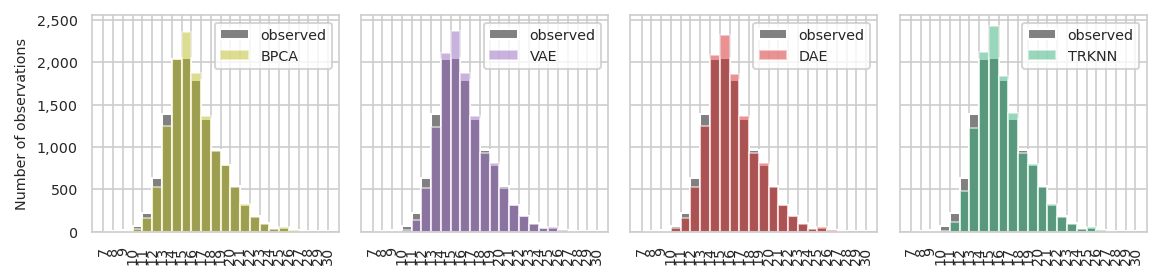

In [40]:
min_max = pimmslearn.plotting.data.min_max(pred_test[TARGET_COL])
top_n = 4
fig, axes = plt.subplots(ncols=top_n, figsize=(8, 2), sharey=True)

for model, color, ax in zip(
        ORDER_MODELS[:top_n],
        COLORS_TO_USE[:top_n],
        axes):

    ax, bins = pimmslearn.plotting.data.plot_histogram_intensities(
        pred_test[TARGET_COL],
        color='grey',
        min_max=min_max,
        ax=ax
    )
    ax, _ = pimmslearn.plotting.data.plot_histogram_intensities(
        pred_test[model],
        color=color,
        min_max=min_max,
        ax=ax,
        alpha=0.5,
    )
    _ = [(l_.set_rotation(90))
         for l_ in ax.get_xticklabels()]
    ax.legend()

axes[0].set_ylabel('Number of observations')

fname = args.out_figures / f'2_{group}_intensity_binned_top_{top_n}_models_test.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(fig, name=fname)

In [41]:
counts_per_bin = pimmslearn.pandas.get_counts_per_bin(df=pred_test,
                                                bins=bins,
                                                columns=[TARGET_COL, *ORDER_MODELS[:top_n]])

counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _series = (pd.cut(df[col], bins=bins).to_frame().groupby(col).size())
/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _series = (pd.cut(df[col], bins=bins).to_frame().groupby(col).size())
/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9

observed  BPCA   VAE   DAE  TRKNN
bin                                        
(7, 8]           2     0     0     1      0
(8, 9]           7     0     0     0      0
(9, 10]         18     2     0     2      1
(10, 11]        69    29    20    44     13
(11, 12]       217   165   143   157    113
(12, 13]       634   531   520   527    479
(13, 14]     1,394 1,248 1,233 1,246  1,224
(14, 15]     2,042 2,033 2,112 2,088  2,118
(15, 16]     2,054 2,359 2,371 2,321  2,429
(16, 17]     1,787 1,867 1,866 1,856  1,842
(17, 18]     1,333 1,363 1,362 1,370  1,401
(18, 19]       965   956   926   928    923
(19, 20]       792   789   808   805    800
(20, 21]       536   528   513   524    533
(21, 22]       320   322   317   320    323
(22, 23]       182   176   183   187    171
(23, 24]       102    92    87    86     92
(24, 25]        45    38    40    37     37
(25, 26]        50    57    57    59     59
(26, 27]        25    20    17    17     17
(27, 28]         3     2     2     2      2
(28, 29]         8    11    12    10     11
(29, 30]        13    11    10    12     12

### Correlation per sample

In [42]:
corr_per_sample_test = (pred_test
                        .groupby(sample_index_name)
                        .apply(lambda df: df.corr().loc[TARGET_COL])
                        [ORDER_MODELS])
corr_per_sample_test = corr_per_sample_test.join(
    pred_test
    .groupby(sample_index_name)[TARGET_COL]
    .count()
    .rename('n_obs')
)
too_few_obs = corr_per_sample_test['n_obs'] < 3
corr_per_sample_test.loc[~too_few_obs].describe()

BPCA     VAE     DAE   TRKNN      RF      CF    KNN5     KNN  \
count 210.000 210.000 210.000 210.000 210.000 210.000 210.000 210.000   
mean    0.969   0.968   0.968   0.966   0.966   0.967   0.965   0.963   
std     0.017   0.019   0.018   0.019   0.018   0.016   0.018   0.019   
min     0.878   0.867   0.895   0.858   0.883   0.906   0.870   0.888   
25%     0.962   0.963   0.962   0.960   0.960   0.959   0.956   0.953   
50%     0.973   0.972   0.972   0.970   0.970   0.970   0.970   0.968   
75%     0.981   0.980   0.980   0.979   0.978   0.978   0.979   0.978   
max     0.994   0.993   0.993   0.992   0.991   0.992   0.992   0.990   

       KNN_IMPUTE     IRM  ...  SVDMETHOD      PI  MINDET  MINPROB  MINIMUM  \
count     210.000 210.000  ...    210.000 210.000   0.000  210.000    0.000   
mean        0.948   0.952  ...      0.076   0.018     NaN   -0.012      NaN   
std         0.035   0.022  ...      0.192   0.129     NaN    0.130      NaN   
min         0.722   0.865  ...     -0.402  -0.343     NaN   -0.411      NaN   
25%         0.938   0.943  ...     -0.059  -0.062     NaN   -0.090      NaN   
50%         0.958   0.956  ...      0.067   0.017     NaN   -0.037      NaN   
75%         0.969   0.966  ...      0.200   0.098     NaN    0.084      NaN   
max         0.987   0.988  ...      0.546   0.367     NaN    0.350      NaN   

       ZERO  IMPSEQROB    MLE  IMPSEQ   n_obs  
count 0.000    210.000 30.000   0.000 210.000  
mean    NaN      0.371 -0.018     NaN  60.000  
std     NaN      0.139  0.151     NaN   9.810  
min     NaN      0.021 -0.287     NaN  31.000  
25%     NaN      0.288 -0.118     NaN  53.000  
50%     NaN      0.368 -0.042     NaN  60.000  
75%     NaN      0.448  0.062     NaN  67.000  
max     NaN      0.889  0.393     NaN  86.000  

[8 rows x 25 columns]

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_pred_corr_test_per_sample.pdf


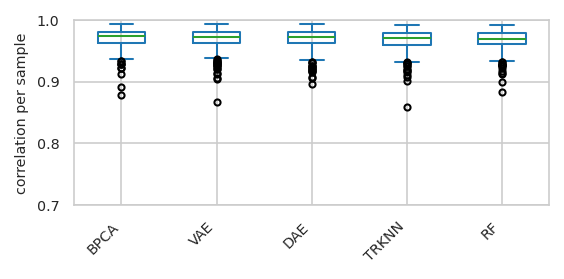

In [43]:
# ! add minimum
kwargs = dict(ylim=(0.7, 1), rot=90,
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model predictions per sample on test data',
              ylabel='correlation per sample')
ax = (corr_per_sample_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_sample.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_sample_test.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_test.to_excel(w, sheet_name='correlations')
    corr_per_sample_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [44]:
treshold = pimmslearn.pandas.get_lower_whiskers(
    corr_per_sample_test[TOP_N_ORDER]).min()
mask = (corr_per_sample_test[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_test.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

In [45]:
feature_names = pred_test.index.levels[-1]
N_SAMPLES = pred_test.index
M = len(feature_names)
pred_test.loc[pd.IndexSlice[:, feature_names[random.randint(0, M - 1)]], :]

observed   BPCA    VAE    DAE  TRKNN     RF     CF  \
Sample ID  protein groups                                                       
Sample_039 Q9NUQ9            12.609 12.654 12.752 12.464 12.826 12.686 12.427   
Sample_057 Q9NUQ9            12.401 12.470 12.862 12.955 13.121 12.849 12.582   
Sample_063 Q9NUQ9            12.974 13.398 13.290 13.459 13.512 12.946 13.236   
Sample_067 Q9NUQ9            13.447 12.777 12.653 12.695 12.811 12.749 12.697   
Sample_095 Q9NUQ9            12.595 12.385 12.701 12.472 13.047 12.655 12.900   
Sample_096 Q9NUQ9            13.211 13.112 13.148 13.078 13.232 12.988 13.376   
Sample_114 Q9NUQ9            12.759 12.772 13.067 13.077 13.433 12.852 12.741   
Sample_115 Q9NUQ9            13.562 12.745 12.936 12.905 13.340 12.830 12.575   
Sample_120 Q9NUQ9            11.726 12.612 12.429 12.574 12.740 12.775 12.985   
Sample_123 Q9NUQ9            12.985 12.538 12.538 12.546 12.533 12.545 12.612   
Sample_156 Q9NUQ9            12.980 12.514 12.412 11.888 12.427 12.569 12.594   
Sample_158 Q9NUQ9            12.879 12.551 12.176 12.101 12.358 12.560 12.033   
Sample_172 Q9NUQ9            12.201 12.746 12.995 12.813 12.878 12.905 12.887   

                            KNN5    KNN  KNN_IMPUTE  ...  SVDMETHOD     PI  \
Sample ID  protein groups                            ...                     
Sample_039 Q9NUQ9         12.972 12.812      12.772  ...     18.443 12.829   
Sample_057 Q9NUQ9         12.982 13.086      12.381  ...     17.657 13.197   
Sample_063 Q9NUQ9         13.345 13.211      13.520  ...     17.001 13.122   
Sample_067 Q9NUQ9         12.921 12.818      13.041  ...     17.023 10.723   
Sample_095 Q9NUQ9         12.878 12.746      12.494  ...     17.183 12.428   
Sample_096 Q9NUQ9         13.155 13.221      13.030  ...     17.227 12.048   
Sample_114 Q9NUQ9         12.935 12.800      12.411  ...     16.992 12.143   
Sample_115 Q9NUQ9         12.816 12.540      12.329  ...     17.365 11.411   
Sample_120 Q9NUQ9         12.826 12.916      13.606  ...     17.073 12.940   
Sample_123 Q9NUQ9         12.796 12.698      13.538  ...     16.971 12.780   
Sample_156 Q9NUQ9         12.364 11.966      12.950  ...     17.747 11.767   
Sample_158 Q9NUQ9         12.163 11.944      13.040  ...     17.290 12.038   
Sample_172 Q9NUQ9         12.801 12.725      13.071  ...     17.137 12.762   

                           MINDET  MINPROB  MINIMUM  ZERO  IMPSEQROB  \
Sample ID  protein groups                                              
Sample_039 Q9NUQ9          12.379   12.690    7.068     0     34.505   
Sample_057 Q9NUQ9          12.440   11.670    7.068     0     12.121   
Sample_063 Q9NUQ9          11.903   11.579    7.068     0     59.205   
Sample_067 Q9NUQ9          11.827   11.557    7.068     0     16.445   
Sample_095 Q9NUQ9          11.709   11.703    7.068     0     32.012   
Sample_096 Q9NUQ9          12.245   12.645    7.068     0     23.989   
Sample_114 Q9NUQ9          11.786   11.818    7.068     0     34.968   
Sample_115 Q9NUQ9          12.275   12.518    7.068     0     21.211   
Sample_120 Q9NUQ9          11.384   11.682    7.068     0    -17.482   
Sample_123 Q9NUQ9          12.689   12.162    7.068     0    -18.930   
Sample_156 Q9NUQ9          12.487   12.971    7.068     0    -12.483   
Sample_158 Q9NUQ9          11.916   11.224    7.068     0    -24.677   
Sample_172 Q9NUQ9          12.508   12.466    7.068     0      7.124   

                                MLE  IMPSEQ  freq  
Sample ID  protein groups                          
Sample_039 Q9NUQ9         2,591.044     NaN   123  
Sample_057 Q9NUQ9         2,580.387     NaN   123  
Sample_063 Q9NUQ9         2,580.996     NaN   123  
Sample_067 Q9NUQ9         2,569.564     NaN   123  
Sample_095 Q9NUQ9         2,629.327     NaN   123  
Sample_096 Q9NUQ9         2,549.026     NaN   123  
Sample_114 Q9NUQ9            16.613     NaN   123  
Sample_115 Q9NUQ9         2,634.625     NaN   123  
Sample_120 Q9NUQ9            19.725    

In [46]:
options = random.sample(sorted(set(feature_names)), 1)
pred_test.loc[pd.IndexSlice[:, options[0]], :]

observed   BPCA    VAE    DAE  TRKNN     RF     CF  \
Sample ID  protein groups                                                       
Sample_008 Q99574            18.325 18.478 18.481 18.429 18.471 18.361 18.326   
Sample_043 Q99574            18.938 18.746 19.015 18.691 18.845 18.500 18.665   
Sample_069 Q99574            18.337 18.762 18.597 18.522 18.684 18.777 18.681   
Sample_081 Q99574            18.259 18.357 18.377 18.612 18.274 18.451 18.595   
Sample_085 Q99574            18.614 18.557 18.492 18.527 18.530 18.454 18.548   
Sample_177 Q99574            18.080 17.796 17.830 17.855 17.706 17.956 17.954   
Sample_187 Q99574            18.751 18.530 18.382 18.438 18.577 18.599 18.646   
Sample_195 Q99574            18.390 18.308 18.213 18.302 18.162 18.378 18.495   

                            KNN5    KNN  KNN_IMPUTE  ...  SVDMETHOD     PI  \
Sample ID  protein groups                            ...                     
Sample_008 Q99574         18.591 18.402      18.568  ...     17.233 13.776   
Sample_043 Q99574         18.825 18.798      18.807  ...     17.481 12.901   
Sample_069 Q99574         18.692 18.839      18.667  ...     17.010 13.375   
Sample_081 Q99574         18.337 18.414      18.233  ...     17.001 11.802   
Sample_085 Q99574         18.485 18.402      18.371  ...     17.221 12.622   
Sample_177 Q99574         18.264 18.108      17.775  ...     17.324 11.648   
Sample_187 Q99574         18.607 18.487      18.355  ...     16.953 11.724   
Sample_195 Q99574         18.431 18.533      18.052  ...     17.117 10.845   

                           MINDET  MINPROB  MINIMUM  ZERO  IMPSEQROB  \
Sample ID  protein groups                                              
Sample_008 Q99574          12.288   12.500    7.068     0     40.625   
Sample_043 Q99574          12.441   12.802    7.068     0   -110.773   
Sample_069 Q99574          11.631   11.801    7.068     0    159.875   
Sample_081 Q99574          12.067   12.814    7.068     0     60.279   
Sample_085 Q99574          12.550   11.729    7.068     0     82.411   
Sample_177 Q99574          12.140   12.119    7.068     0     64.433   
Sample_187 Q99574          12.471   13.513    7.068     0     68.128   
Sample_195 Q99574          12.219   12.055    7.068     0    -39.306   

                                MLE  IMPSEQ  freq  
Sample ID  protein groups                          
Sample_008 Q99574         2,555.081     NaN   210  
Sample_043 Q99574         2,455.484     NaN   210  
Sample_069 Q99574         2,567.211     NaN   210  
Sample_081 Q99574         2,631.820     NaN   210  
Sample_085 Q99574         2,494.406     NaN   210  
Sample_177 Q99574            16.051     NaN   210  
Sample_187 Q99574         2,508.616     NaN   210  
Sample_195 Q99574         2,568.559     NaN   210  

[8 rows x 26 columns]

### Correlation per feature

In [47]:
corr_per_feat_test = pred_test.groupby(FEAT_NAME).apply(
    lambda df: df.corr().loc[TARGET_COL])[ORDER_MODELS]
corr_per_feat_test = corr_per_feat_test.join(pred_test.groupby(FEAT_NAME)[
    TARGET_COL].count().rename('n_obs'))

too_few_obs = corr_per_feat_test['n_obs'] < 3
corr_per_feat_test.loc[~too_few_obs].describe()

BPCA       VAE       DAE     TRKNN        RF        CF      KNN5  \
count 1,396.000 1,396.000 1,396.000 1,396.000 1,396.000 1,396.000 1,396.000   
mean      0.636     0.636     0.639     0.607     0.591     0.601     0.564   
std       0.337     0.331     0.346     0.342     0.344     0.346     0.359   
min      -0.998    -1.000    -0.988    -0.977    -0.996    -1.000    -0.983   
25%       0.506     0.493     0.504     0.455     0.435     0.450     0.392   
50%       0.746     0.746     0.757     0.706     0.690     0.702     0.677   
75%       0.880     0.876     0.885     0.859     0.848     0.851     0.833   
max       0.999     0.999     0.999     1.000     0.999     1.000     0.999   

            KNN  KNN_IMPUTE       IRM  ...  SVDMETHOD        PI    MINDET  \
count 1,396.000   1,396.000 1,396.000  ...  1,396.000 1,396.000 1,396.000   
mean      0.538       0.445     0.470  ...     -0.008     0.013     0.086   
std       0.369       0.422     0.388  ...      0.447     0.395     0.441   
min      -0.991      -1.000    -0.999  ...     -0.999    -0.999    -0.999   
25%       0.359       0.221     0.266  ...     -0.341    -0.265    -0.242   
50%       0.634       0.554     0.554  ...     -0.005     0.027     0.118   
75%       0.809       0.770     0.768  ...      0.331     0.291     0.425   
max       1.000       1.000     0.998  ...      0.999     1.000     0.999   

        MINPROB  MINIMUM  ZERO  IMPSEQROB       MLE  IMPSEQ     n_obs  
count 1,396.000    0.000 0.000  1,396.000 1,396.000   0.000 1,396.000  
mean      0.030      NaN   NaN     -0.009    -0.016     NaN     8.999  
std       0.420      NaN   NaN      0.411     0.433     NaN     3.913  
min      -0.999      NaN   NaN     -1.000    -0.999     NaN     3.000  
25%      -0.273      NaN   NaN     -0.285    -0.313     NaN     6.000  
50%       0.050      NaN   NaN      0.004    -0.016     NaN     8.000  
75%       0.341      NaN   NaN      0.268     0.294     NaN    11.000  
max       0.997      NaN   NaN      0.992     0.998     NaN    32.000  

[8 rows x 25 columns]

In [48]:
corr_per_feat_test.loc[too_few_obs].dropna(thresh=3, axis=0)

BPCA    VAE  \
protein groups                                                            
A0A0A0MS09;P01880;P01880-2                                 1.000  1.000   
A0A0C4DGV4;E9PLX3;O43504;R4GMU8                            1.000  1.000   
A0A0C4DH29                                                -1.000 -1.000   
A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3 -1.000  1.000   
A6H8L4;E7EUI5;P78536;P78536-2                              1.000  1.000   
D6RF35                                                     1.000  1.000   
E7EQ64;P07477                                              1.000  1.000   
F8WDW9;Q96AP7                                             -1.000  1.000   
J3KRP0                                                     1.000  1.000   
O43581-2;O43581-3;O43581-5                                -1.000 -1.000   
P04075                                                     1.000  1.000   
P04080                                                     1.000  1.000   
P33151                                                     1.000  1.000   
P62258                                                     1.000  1.000   
Q9NYQ8                                                     1.000  1.000   
Q9Y281;Q9Y281-3                                            1.000  1.000   

                                                             DAE  TRKNN  \
protein groups                                                            
A0A0A0MS09;P01880;P01880-2                                 1.000  1.000   
A0A0C4DGV4;E9PLX3;O43504;R4GMU8                            1.000 -1.000   
A0A0C4DH29                                                 1.000 -1.000   
A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3  1.000  1.000   
A6H8L4;E7EUI5;P78536;P78536-2                             -1.000 -1.000   
D6RF35                                                     1.000  1.000   
E7EQ64;P07477                                              1.000  1.000   
F8WDW9;Q96AP7                                              1.000 -1.000   
J3KRP0                                                     1.000  1.000   
O43581-2;O43581-3;O43581-5                                -1.000 -1.000   
P04075                                                     1.000  1.000   
P04080                                                     1.000  1.000   
P33151                                                     1.000  1.000   
P62258                                                     1.000  1.000   
Q9NYQ8                                                     1.000  1.000   
Q9Y281;Q9Y281-3                                            1.000  1.000   

                                                              RF     CF  \
protein groups                                                            
A0A0A0MS09;P01880;P01880-2                                 1.000 -1.000   
A0A0C4DGV4;E9PLX3;O43504;R4GMU8                            1.000  1.000   
A0A0C4DH29                                                -1.000 -1.000   
A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3  1.000  1.000   
A6H8L4;E7EUI5;P78536;P78536-2                             -1.000  1.000   
D6RF35                                                     1.000  1.000   
E7EQ64;P07477                                              1.000 -1.000   
F8WDW9;Q96AP7                                             -1.000 -1.000   
J3KRP0                                                     1.000  1.000   
O43581-2;O43581-3;O43581-5                                -1.000 -1.000   
P04075                                                     1.000  1.000   
P04080                                                     1.000  1.000   
P33151                                                     1.000  1.000   
P62258                                                     1.000  1.000   
Q9NYQ8                                                     1.000 -1.000   
Q9Y281;Q9Y281-3                                           -1.000  1.000   

       

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_pred_corr_test_per_feat.pdf


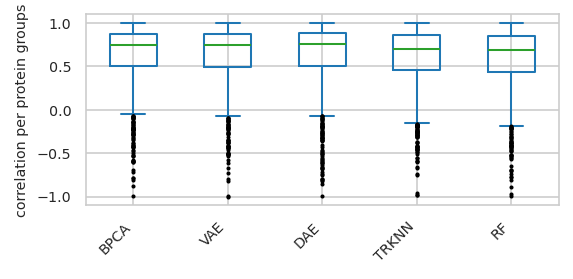

In [49]:
kwargs = dict(rot=90,
              flierprops=dict(markersize=1),
              ylabel=f'correlation per {FEAT_NAME_DISPLAY}')
ax = (corr_per_feat_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs)
      )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_feat.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)
dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_feat_test.loc[~too_few_obs].describe().to_excel(
        w, sheet_name='summary')
    corr_per_feat_test.to_excel(w, sheet_name='correlations')
    corr_per_feat_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

In [50]:
feat_count_test = data.test_y.stack().groupby(FEAT_NAME).count()
feat_count_test.name = 'count'
feat_count_test.head()

protein groups
A0A024QZX5;A0A087X1N8;P35237                                                     10
A0A024R0T9;K7ER74;P02655                                                          8
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8    6
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                           8
A0A075B6H7                                                                        4
Name: count, dtype: int64

In [51]:
treshold = pimmslearn.pandas.get_lower_whiskers(
    corr_per_feat_test[TOP_N_ORDER]).min()
mask = (corr_per_feat_test[TOP_N_ORDER] < treshold).any(axis=1)


def highlight_min(s, color, tolerence=0.00001):
    return np.where((s - s.min()).abs() < tolerence, f"background-color: {color};", None)


view = (corr_per_feat_test
        .join(feat_count_test)
        .loc[mask]
        .sort_values('count'))

if not view.empty:
    display(view
            .style.
            apply(highlight_min, color='yellow', axis=1,
                  subset=corr_per_feat_test.columns)
            )
else:
    print("None found")

### Error plot

In [52]:
metrics = pimmslearn.models.Metrics()
test_metrics = metrics.add_metrics(
    pred_test[['observed', *TOP_N_ORDER]], key='test data')
test_metrics = pd.DataFrame(test_metrics)[TOP_N_ORDER]
test_metrics

Selected as truth to compare to: observed


BPCA        VAE        DAE      TRKNN         RF
MSE       0.455      0.477      0.474      0.500      0.512
MAE       0.432      0.435      0.435      0.458      0.465
N    12,600.000 12,600.000 12,600.000 12,600.000 12,600.000
prop      1.000      1.000      1.000      1.000      1.000

In [53]:
n_in_comparison = int(test_metrics.loc['N'].unique()[0])
n_in_comparison

12600

In [54]:
_to_plot = test_metrics.loc[METRIC].to_frame().T
_to_plot.index = [feature_names.name]
_to_plot

BPCA   VAE   DAE  TRKNN    RF
protein groups 0.432 0.435 0.435  0.458 0.465

In [55]:
try:
    text = model_configs[["latent_dim", "hidden_layers"]].apply(
        build_text,
        axis=1)
except KeyError:
    logger.warning("No PIMMS models in comparsion. Using empty text")
    text = pd.Series('', index=model_configs.columns)

_to_plot.loc["text"] = text
_to_plot = _to_plot.fillna('')
_to_plot

BPCA            VAE            DAE TRKNN    RF
protein groups 0.432          0.435          0.435 0.458 0.465
text                  LD: 10 HL: 64  LD: 10 HL: 64

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_performance_test.pdf


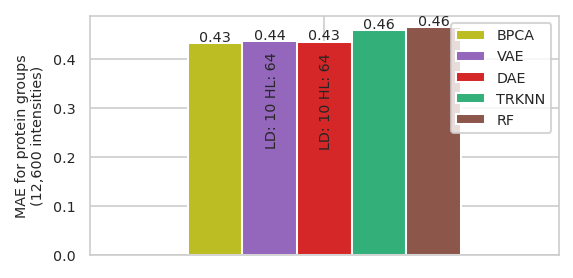

In [56]:
fig, ax = plt.subplots(figsize=(4, 2))  # size of the plot can be adjusted
ax = _to_plot.loc[[feature_names.name]].plot.bar(
    rot=0,
    ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY}\n({n_in_comparison:,} intensities)",
    # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
    color=COLORS_TO_USE,
    ax=ax,
    width=.7)
ax = pimmslearn.plotting.add_height_to_barplot(ax, size=7)
ax = pimmslearn.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=7)
ax.set_xticklabels([])
fname = args.out_figures / f'2_{group}_performance_test.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(fig, name=fname)

In [57]:
dumps[fname.stem] = fname.with_suffix('.csv')
_to_plot_long = _to_plot.T
_to_plot_long = _to_plot_long.rename(
    {feature_names.name: 'metric_value'}, axis=1)
_to_plot_long['data level'] = feature_names.name
_to_plot_long = _to_plot_long.set_index('data level', append=True)
_to_plot_long.to_csv(fname.with_suffix('.csv'))

### Plot error by median feature intensity

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/errors.py:99: UserWarning: The palette list has more values (24) than needed (5), which may not be intended.
  sns.barplot(data=errors,
/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/errors.py:99: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.barplot(data=errors,


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_test_errors_binned_by_feat_medians.pdf


Sample ID     protein groups  model   MAE  bin  n_obs  \
0       Sample_000  A0A075B6P5;P01615   BPCA 0.467   19    912   
1       Sample_000  A0A075B6P5;P01615    VAE 0.417   19    912   
2       Sample_000  A0A075B6P5;P01615    DAE 0.317   19    912   
3       Sample_000  A0A075B6P5;P01615  TRKNN 0.422   19    912   
4       Sample_000  A0A075B6P5;P01615     RF 0.626   19    912   
...            ...                ...    ...   ...  ...    ...   
62,995  Sample_209    Q9UGM5;Q9UGM5-2   BPCA 0.476   16  1,913   
62,996  Sample_209    Q9UGM5;Q9UGM5-2    VAE 0.288   16  1,913   
62,997  Sample_209    Q9UGM5;Q9UGM5-2    DAE 0.434   16  1,913   
62,998  Sample_209    Q9UGM5;Q9UGM5-2  TRKNN 0.442   16  1,913   
62,999  Sample_209    Q9UGM5;Q9UGM5-2     RF 0.293   16  1,913   

       intensity binned by median of protein groups  
0                                       19\n(N=912)  
1                                       19\n(N=912)  
2                                       19\n(N=912)  
3                                       19\n(N=912)  
4                                       19\n(N=912)  
...                                             ...  
62,995                                16\n(N=1,913)  
62,996                                16\n(N=1,913)  
62,997                                16\n(N=1,913)  
62,998                                16\n(N=1,913)  
62,999                                16\n(N=1,913)  

[63000 rows x 7 columns]

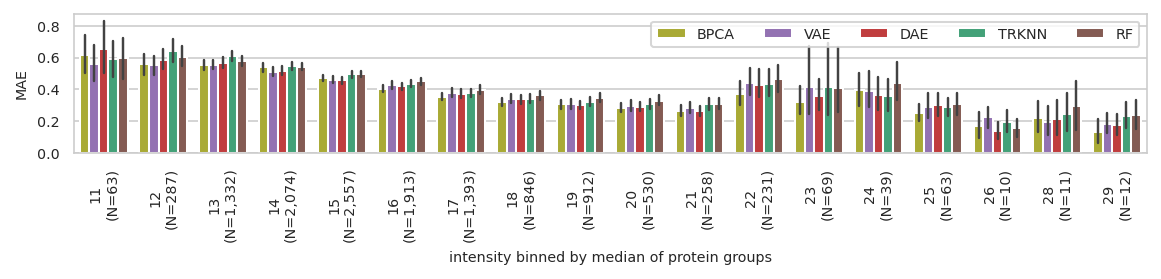

In [58]:
pimmslearn.plotting.make_large_descriptors(7)
fig, ax = plt.subplots(figsize=(8, 2))

ax, errors_binned = pimmslearn.plotting.errors.plot_errors_by_median(
    pred=pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC,
    palette=COLORS_TO_USE
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
pimmslearn.plotting.make_large_descriptors(6)
fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned

In [59]:
# ! only used for reporting
plotted = pimmslearn.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

bin  model  mean  ci_low  ci_high
0   11\n(N=63)   BPCA 0.619   0.504    0.744
1   11\n(N=63)    DAE 0.656   0.514    0.822
2   11\n(N=63)     RF 0.595   0.471    0.731
3   11\n(N=63)  TRKNN 0.589   0.482    0.698
4   11\n(N=63)    VAE 0.561   0.454    0.677
..         ...    ...   ...     ...      ...
85  29\n(N=12)   BPCA 0.133   0.065    0.212
86  29\n(N=12)    DAE 0.175   0.115    0.251
87  29\n(N=12)     RF 0.241   0.156    0.331
88  29\n(N=12)  TRKNN 0.230   0.158    0.317
89  29\n(N=12)    VAE 0.184   0.120    0.252

[90 rows x 5 columns]

In [60]:
(errors_binned
 .set_index(
     ['model', errors_binned.columns[-1]]
 )
 .loc[ORDER_MODELS[0]]
 .sort_values(by=METRIC))

Sample ID  \
intensity binned by median of protein groups               
18\n(N=846)                                   Sample_142   
15\n(N=2,557)                                 Sample_021   
14\n(N=2,074)                                 Sample_058   
16\n(N=1,913)                                 Sample_015   
15\n(N=2,557)                                 Sample_079   
...                                                  ...   
14\n(N=2,074)                                 Sample_011   
14\n(N=2,074)                                 Sample_184   
17\n(N=1,393)                                 Sample_108   
14\n(N=2,074)                                 Sample_091   
14\n(N=2,074)                                 Sample_115   

                                                                      protein groups  \
intensity binned by median of protein groups                                           
18\n(N=846)                                                                   P09972   
15\n(N=2,557)                                                             A0A0A0MT66   
14\n(N=2,074)                                                        Q16853;Q16853-2   
16\n(N=1,913)                                 B7Z2R4;C9JR67;O43556;O43556-3;O43556-4   
15\n(N=2,557)                                                 A6NCT7;Q07092;Q07092-2   
...                                                                              ...   
14\n(N=2,074)                                                        P11597;P11597-2   
14\n(N=2,074)                                                          F8WD41;Q15166   
17\n(N=1,393)                                                        P27824;P27824-2   
14\n(N=2,074)                                                          F8WD41;Q15166   
14\n(N=2,074)                                                                 P17050   

                                               MAE  bin  n_obs  
intensity binned by median of protein groups                    
18\n(N=846)                                  0.000   18    846  
15\n(N=2,557)                                0.000   15  2,557  
14\n(N=2,074)                                0.000   14  2,074  
16\n(N=1,913)                                0.000   16  1,913  
15\n(N=2,557)                                0.000   15  2,557  
...                                            ...  ...    ...  
14\n(N=2,074)                                5.771   14  2,074  
14\n(N=2,074)                                6.195   14  2,074  
17\n(N=1,393)                                6.482   17  1,393  
14\n(N=2,074)                                6.823   14  2,074  
14\n(N=2,074)                                7.635   14  2,074  

[12600 rows x 5 columns]

### Custom model selection

In [61]:
if SEL_MODELS:
    metrics = pimmslearn.models.Metrics()
    test_metrics = metrics.add_metrics(
        pred_test[['observed', *SEL_MODELS]], key='test data')
    test_metrics = pd.DataFrame(test_metrics)[SEL_MODELS]
    test_metrics

    n_in_comparison = int(test_metrics.loc['N'].unique()[0])
    n_in_comparison

    _to_plot = test_metrics.loc[METRIC].to_frame().T
    _to_plot.index = [feature_names.name]
    _to_plot

    try:
        text = model_configs[["latent_dim", "hidden_layers"]].apply(
            build_text,
            axis=1)
    except KeyError:
        logger.warning("No PIMMS models in comparsion. Using empty text")
        text = pd.Series('', index=model_configs.columns)

    _to_plot.loc["text"] = text
    _to_plot = _to_plot.fillna('')
    _to_plot

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = _to_plot.loc[[feature_names.name]].plot.bar(
        rot=0,
        ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY} ({n_in_comparison:,} intensities)",
        # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
        color=pimmslearn.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS)),
        ax=ax,
        width=.7)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    ax = pimmslearn.plotting.add_height_to_barplot(ax, size=5)
    ax = pimmslearn.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=5)
    ax.set_xticklabels([])

    fname = args.out_figures / f'2_{group}_performance_test_sel.pdf'
    figures[fname.stem] = fname
    pimmslearn.savefig(fig, name=fname)

    dumps[fname.stem] = fname.with_suffix('.csv')
    _to_plot_long = _to_plot.T
    _to_plot_long = _to_plot_long.rename(
        {feature_names.name: 'metric_value'}, axis=1)
    _to_plot_long['data level'] = feature_names.name
    _to_plot_long = _to_plot_long.set_index('data level', append=True)
    _to_plot_long.to_csv(fname.with_suffix('.csv'))

In [62]:
# custom selection
if SEL_MODELS:
    pimmslearn.plotting.make_large_descriptors(7)
    fig, ax = plt.subplots(figsize=(8, 2))

    ax, errors_binned = pimmslearn.plotting.errors.plot_errors_by_median(
        pred=pred_test[
            [TARGET_COL] + SEL_MODELS
        ],
        feat_medians=data.train_X.median(),
        ax=ax,
        metric_name=METRIC,
        feat_name=FEAT_NAME_DISPLAY,
        palette=pimmslearn.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS))
    )
    # ax.set_ylim(0, 1.5)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    # for text in ax.legend().get_texts():
    #     text.set_fontsize(6)
    fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians_sel.pdf'
    figures[fname.stem] = fname
    pimmslearn.savefig(ax.get_figure(), name=fname)
    plt.show(fig)

    dumps[fname.stem] = fname.with_suffix('.csv')
    errors_binned.to_csv(fname.with_suffix('.csv'))
    pimmslearn.plotting.make_large_descriptors(6)
    # ax.xaxis.set_tick_params(rotation=0) # horizontal

    # ! only used for reporting
    plotted = pimmslearn.plotting.errors.get_data_for_errors_by_median(
        errors=errors_binned,
        feat_name=FEAT_NAME_DISPLAY,
        metric_name=METRIC
    )
    plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
    display(plotted)

### Error by non-decimal number of intensity

- number of observations in parentheses.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/errors.py:45: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(data=errors_binned, ax=ax,


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/2_1_test_errors_binned_by_int.pdf


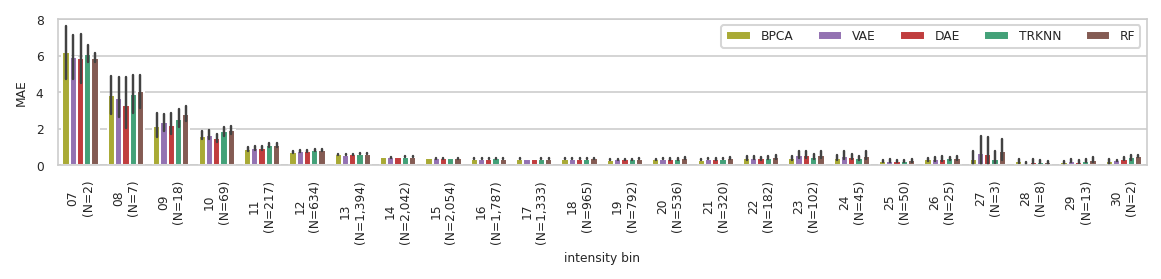

In [63]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_binned = pimmslearn.plotting.errors.plot_errors_binned(
    pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    ax=ax,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_test_errors_binned_by_int.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), name=fname)

In [64]:
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

Sample ID protein groups  model   MAE intensity bin
0  Sample_143         P02768   BPCA 0.065     30\n(N=2)
1  Sample_143         P02768    VAE 0.250     30\n(N=2)
2  Sample_143         P02768    DAE 0.443     30\n(N=2)
3  Sample_143         P02768  TRKNN 0.574     30\n(N=2)
4  Sample_143         P02768     RF 0.457     30\n(N=2)

## Figures dumped to disk

In [65]:
figures

{'2_1_fake_na_val_test_splits': Path('runs/alzheimer_study/figures/2_1_fake_na_val_test_splits.png'),
 '2_1_pred_corr_val_per_sample': Path('runs/alzheimer_study/figures/2_1_pred_corr_val_per_sample.pdf'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/alzheimer_study/figures/2_1_errors_binned_by_feat_median_val.pdf'),
 '2_1_intensity_binned_top_4_models_test': Path('runs/alzheimer_study/figures/2_1_intensity_binned_top_4_models_test.pdf'),
 '2_1_pred_corr_test_per_sample': Path('runs/alzheimer_study/figures/2_1_pred_corr_test_per_sample.pdf'),
 '2_1_pred_corr_test_per_feat': Path('runs/alzheimer_study/figures/2_1_pred_corr_test_per_feat.pdf'),
 '2_1_performance_test': Path('runs/alzheimer_study/figures/2_1_performance_test.pdf'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/alzheimer_study/figures/2_1_test_errors_binned_by_feat_medians.pdf'),
 '2_1_test_errors_binned_by_int': Path('runs/alzheimer_study/figures/2_1_test_errors_binned_by_int.pdf')}

In [66]:
dumps
print("done")

done
